In [4]:
import xarray as xr
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load the input dataset

In [5]:
my_ds = xr.open_mfdataset('/lambda_stor/data/rjackson/coverage_product/*.nc')
my_ds

/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


,Array,Chunk
Bytes,11.63 MB,10.30 kB
Shape,"(14679, 99)","(13, 99)"
Count,3810 Tasks,1270 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,11.63 MB,10.30 kB
Shape,"(14679, 99)","(13, 99)"
Count,3810 Tasks,1270 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


## Create autoencoder from % coverage SNR

Dataset for this problem:

3 months of ARM Doppler Lidar data at SGP. At 100 height bins, I calculate the statistical coverage product of signal-to-noise ratio for five minute periods. The features for this dataset are the percentage of gates in the height and time interval where the SNR is > 1, 3, 5, or 10 dB. In total, each five minute time period has 396 features. What we want to do is to reduce this down to a more usable number of features in a process called dimensionality reduction.

We first have to load in the coverage data into a 2D array of *n_samples* by *n_features*. Here, we have 396 features, one for each of the 99 height levels for the four SNR thresholds. We then have to remove completely zero time periods where we have no data. 

In [12]:
snr_scp = np.concatenate([my_ds['snrgt1.000000'].values, my_ds['snrgt3.000000'].values,
                          my_ds['snrgt5.000000'].values, my_ds['snrgt10.000000'].values], axis=1)
snr_scp = np.nan_to_num(snr_scp)
gt0 = snr_scp.sum(axis=1) > 0
snr_scp = snr_scp[gt0, :]

In [51]:
snr_scp.shape

(14163, 396)

A common technique for dimensionality reduction in machine learning that is useful when the covariance between variables is nonlinear is to use an autoencoder. An autoencoder is a neural network that describes a function $f(x) = x$. In essence, the input is equal to the output. However, the structure is such that the middle layer of the network is an encoding of the input space. Therefore, on the left we have the encoder and on the right we have the decoder.

This is the general structure of an encoder-decoder model.

<img src=https://www.compthree.com/images/blog/ae/ae.png width="600" height="600">

What we are interested in here are the values from the middle layer of the neural network, also known as the latent space. However, we don't know these values without training the whole network including both the encoder and decoder, since all we know is the value of $x$. Therefore, we need to train the complete model first, then when we want just the encodings we will remove the decoder layers and then predict the encodings from the trained encoder model.

Once we have the encoder to produce the latent space, then it becomes more feasible to use clustering techniques on the data to learn about how your dataset is grouped together.

In [7]:
def model(input_ds):
    inp = Input(shape=(input_ds.shape[1]), name='input')
    
    layer1 = Dense(128, activation='relu', name='EncDense')(inp)
    encoding = Dense(10, name='code')(layer1)
    layer1_dec = Dense(128, activation='relu', name='DecDense')(encoding)
    decoding = Dense(input_ds.shape[1], name='output')(layer1_dec)
    
    autoencoder = Model(inp, decoding)
    return autoencoder

In this example above, I am reducing the 396 dimensional input to a 10-dimensional latent space. Usually no more than 5 to 10 dimensions should be used for clustering techniques. 

In [8]:
autoencoder = model(snr_scp)
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 396)]             0         
_________________________________________________________________
EncDense (Dense)             (None, 128)               50816     
_________________________________________________________________
code (Dense)                 (None, 10)                1290      
_________________________________________________________________
DecDense (Dense)             (None, 128)               1408      
_________________________________________________________________
output (Dense)               (None, 396)               51084     
Total params: 104,598
Trainable params: 104,598
Non-trainable params: 0
_________________________________________________________________


In [9]:
autoencoder.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')

In [10]:
x_train, x_test, y_train, y_test = train_test_split(snr_scp, snr_scp)

In [11]:
autoencoder.fit(x_train, y_train, epochs=1000)

Epoch 1/1000
332/332 [==============================] - 0s 830us/step - loss: 31.8086
Epoch 2/1000
332/332 [==============================] - 0s 819us/step - loss: 10.1354
Epoch 3/1000
332/332 [==============================] - 0s 819us/step - loss: 7.8075
Epoch 4/1000
332/332 [==============================] - 0s 837us/step - loss: 6.9196
Epoch 5/1000
332/332 [==============================] - 0s 831us/step - loss: 6.3713
Epoch 6/1000
332/332 [==============================] - 0s 825us/step - loss: 5.9716
Epoch 7/1000
332/332 [==============================] - 0s 830us/step - loss: 5.6476
Epoch 8/1000
332/332 [==============================] - 0s 823us/step - loss: 5.3460
Epoch 9/1000
332/332 [==============================] - 0s 828us/step - loss: 5.0557
Epoch 10/1000
332/332 [==============================] - 0s 821us/step - loss: 4.8254
Epoch 11/1000
332/332 [==============================] - 0s 831us/step - loss: 4.6354
Epoch 12/1000
332/332 [==============================] - 0s 8

332/332 [==============================] - 0s 839us/step - loss: 1.9501
Epoch 97/1000
332/332 [==============================] - 0s 867us/step - loss: 1.9540
Epoch 98/1000
332/332 [==============================] - 0s 829us/step - loss: 1.9537
Epoch 99/1000
332/332 [==============================] - 0s 827us/step - loss: 1.9387
Epoch 100/1000
332/332 [==============================] - 0s 826us/step - loss: 1.9295
Epoch 101/1000
332/332 [==============================] - 0s 819us/step - loss: 1.9549
Epoch 102/1000
332/332 [==============================] - 0s 831us/step - loss: 1.9260
Epoch 103/1000
332/332 [==============================] - 0s 811us/step - loss: 1.9301
Epoch 104/1000
332/332 [==============================] - 0s 830us/step - loss: 1.9093
Epoch 105/1000
332/332 [==============================] - 0s 831us/step - loss: 1.8970
Epoch 106/1000
332/332 [==============================] - 0s 835us/step - loss: 1.9085
Epoch 107/1000
332/332 [==============================] - 0s 

332/332 [==============================] - 0s 824us/step - loss: 1.6393
Epoch 191/1000
332/332 [==============================] - 0s 819us/step - loss: 1.6460
Epoch 192/1000
332/332 [==============================] - 0s 820us/step - loss: 1.6660
Epoch 193/1000
332/332 [==============================] - 0s 823us/step - loss: 1.6246
Epoch 194/1000
332/332 [==============================] - 0s 820us/step - loss: 1.6432
Epoch 195/1000
332/332 [==============================] - 0s 829us/step - loss: 1.6482
Epoch 196/1000
332/332 [==============================] - 0s 828us/step - loss: 1.6580
Epoch 197/1000
332/332 [==============================] - 0s 831us/step - loss: 1.6340
Epoch 198/1000
332/332 [==============================] - 0s 828us/step - loss: 1.6242
Epoch 199/1000
332/332 [==============================] - 0s 829us/step - loss: 1.6491
Epoch 200/1000
332/332 [==============================] - 0s 829us/step - loss: 1.6295
Epoch 201/1000
332/332 [==============================] - 

332/332 [==============================] - 0s 816us/step - loss: 1.5640
Epoch 285/1000
332/332 [==============================] - 0s 825us/step - loss: 1.5697
Epoch 286/1000
332/332 [==============================] - 0s 824us/step - loss: 1.5577
Epoch 287/1000
332/332 [==============================] - 0s 828us/step - loss: 1.5490
Epoch 288/1000
332/332 [==============================] - 0s 824us/step - loss: 1.5441
Epoch 289/1000
332/332 [==============================] - 0s 826us/step - loss: 1.5580
Epoch 290/1000
332/332 [==============================] - 0s 821us/step - loss: 1.5282
Epoch 291/1000
332/332 [==============================] - 0s 827us/step - loss: 1.5291
Epoch 292/1000
332/332 [==============================] - 0s 822us/step - loss: 1.5497
Epoch 293/1000
332/332 [==============================] - 0s 825us/step - loss: 1.5554
Epoch 294/1000
332/332 [==============================] - 0s 835us/step - loss: 1.5589
Epoch 295/1000
332/332 [==============================] - 

332/332 [==============================] - 0s 818us/step - loss: 1.4729
Epoch 379/1000
332/332 [==============================] - 0s 809us/step - loss: 1.4937
Epoch 380/1000
332/332 [==============================] - 0s 814us/step - loss: 1.4826
Epoch 381/1000
332/332 [==============================] - 0s 827us/step - loss: 1.4822
Epoch 382/1000
332/332 [==============================] - 0s 836us/step - loss: 1.4836
Epoch 383/1000
332/332 [==============================] - 0s 840us/step - loss: 1.4975
Epoch 384/1000
332/332 [==============================] - 0s 833us/step - loss: 1.4928
Epoch 385/1000
332/332 [==============================] - 0s 838us/step - loss: 1.4928
Epoch 386/1000
332/332 [==============================] - 0s 834us/step - loss: 1.4784
Epoch 387/1000
332/332 [==============================] - 0s 821us/step - loss: 1.4845
Epoch 388/1000
332/332 [==============================] - 0s 808us/step - loss: 1.4869
Epoch 389/1000
332/332 [==============================] - 

332/332 [==============================] - 0s 887us/step - loss: 1.4417
Epoch 473/1000
332/332 [==============================] - 0s 944us/step - loss: 1.4434
Epoch 474/1000
332/332 [==============================] - 0s 886us/step - loss: 1.4670
Epoch 475/1000
332/332 [==============================] - 0s 948us/step - loss: 1.4432
Epoch 476/1000
332/332 [==============================] - 0s 947us/step - loss: 1.4532
Epoch 477/1000
332/332 [==============================] - 0s 856us/step - loss: 1.4261
Epoch 478/1000
332/332 [==============================] - 0s 823us/step - loss: 1.4308
Epoch 479/1000
332/332 [==============================] - 0s 875us/step - loss: 1.4519
Epoch 480/1000
332/332 [==============================] - 0s 869us/step - loss: 1.4546
Epoch 481/1000
332/332 [==============================] - 0s 860us/step - loss: 1.4882
Epoch 482/1000
332/332 [==============================] - 0s 898us/step - loss: 1.4634
Epoch 483/1000
332/332 [==============================] - 

332/332 [==============================] - 0s 840us/step - loss: 1.4104
Epoch 567/1000
332/332 [==============================] - 0s 835us/step - loss: 1.3976
Epoch 568/1000
332/332 [==============================] - 0s 834us/step - loss: 1.4156
Epoch 569/1000
332/332 [==============================] - 0s 841us/step - loss: 1.4273
Epoch 570/1000
332/332 [==============================] - 0s 838us/step - loss: 1.4039
Epoch 571/1000
332/332 [==============================] - 0s 842us/step - loss: 1.4401
Epoch 572/1000
332/332 [==============================] - 0s 835us/step - loss: 1.4167
Epoch 573/1000
332/332 [==============================] - 0s 830us/step - loss: 1.4219
Epoch 574/1000
332/332 [==============================] - 0s 841us/step - loss: 1.4255
Epoch 575/1000
332/332 [==============================] - 0s 838us/step - loss: 1.4215
Epoch 576/1000
332/332 [==============================] - 0s 824us/step - loss: 1.4299
Epoch 577/1000
332/332 [==============================] - 

332/332 [==============================] - 0s 903us/step - loss: 1.4099
Epoch 661/1000
332/332 [==============================] - 0s 947us/step - loss: 1.4271
Epoch 662/1000
332/332 [==============================] - 0s 866us/step - loss: 1.3951
Epoch 663/1000
332/332 [==============================] - 0s 909us/step - loss: 1.3837
Epoch 664/1000
332/332 [==============================] - 0s 815us/step - loss: 1.3931
Epoch 665/1000
332/332 [==============================] - 0s 856us/step - loss: 1.3950
Epoch 666/1000
332/332 [==============================] - 0s 843us/step - loss: 1.4116
Epoch 667/1000
332/332 [==============================] - 0s 814us/step - loss: 1.3793
Epoch 668/1000
332/332 [==============================] - 0s 906us/step - loss: 1.3979
Epoch 669/1000
332/332 [==============================] - 0s 853us/step - loss: 1.4023
Epoch 670/1000
332/332 [==============================] - 0s 825us/step - loss: 1.3907
Epoch 671/1000
332/332 [==============================] - 

332/332 [==============================] - 0s 827us/step - loss: 1.3978
Epoch 755/1000
332/332 [==============================] - 0s 872us/step - loss: 1.4031
Epoch 756/1000
332/332 [==============================] - 0s 860us/step - loss: 1.3640
Epoch 757/1000
332/332 [==============================] - 0s 891us/step - loss: 1.3709
Epoch 758/1000
332/332 [==============================] - 0s 881us/step - loss: 1.4529
Epoch 759/1000
332/332 [==============================] - 0s 854us/step - loss: 1.3756
Epoch 760/1000
332/332 [==============================] - 0s 811us/step - loss: 1.3608
Epoch 761/1000
332/332 [==============================] - 0s 847us/step - loss: 1.3640
Epoch 762/1000
332/332 [==============================] - 0s 918us/step - loss: 1.3803
Epoch 763/1000
332/332 [==============================] - 0s 861us/step - loss: 1.3612
Epoch 764/1000
332/332 [==============================] - 0s 810us/step - loss: 1.3875
Epoch 765/1000
332/332 [==============================] - 

332/332 [==============================] - 0s 889us/step - loss: 1.3889
Epoch 849/1000
332/332 [==============================] - 0s 876us/step - loss: 1.3712
Epoch 850/1000
332/332 [==============================] - 0s 871us/step - loss: 1.3578
Epoch 851/1000
332/332 [==============================] - 0s 875us/step - loss: 1.3686
Epoch 852/1000
332/332 [==============================] - 0s 880us/step - loss: 1.3601
Epoch 853/1000
332/332 [==============================] - 0s 877us/step - loss: 1.3500
Epoch 854/1000
332/332 [==============================] - 0s 879us/step - loss: 1.3891
Epoch 855/1000
332/332 [==============================] - 0s 886us/step - loss: 1.3579
Epoch 856/1000
332/332 [==============================] - 0s 882us/step - loss: 1.3568
Epoch 857/1000
332/332 [==============================] - 0s 880us/step - loss: 1.3636
Epoch 858/1000
332/332 [==============================] - 0s 878us/step - loss: 1.3632
Epoch 859/1000
332/332 [==============================] - 

332/332 [==============================] - 0s 816us/step - loss: 1.3691
Epoch 943/1000
332/332 [==============================] - 0s 827us/step - loss: 1.3614
Epoch 944/1000
332/332 [==============================] - 0s 822us/step - loss: 1.3365
Epoch 945/1000
332/332 [==============================] - 0s 819us/step - loss: 1.3551
Epoch 946/1000
332/332 [==============================] - 0s 845us/step - loss: 1.3511
Epoch 947/1000
332/332 [==============================] - 0s 844us/step - loss: 1.3563
Epoch 948/1000
332/332 [==============================] - 0s 839us/step - loss: 1.3623
Epoch 949/1000
332/332 [==============================] - 0s 834us/step - loss: 1.3620
Epoch 950/1000
332/332 [==============================] - 0s 861us/step - loss: 1.3542
Epoch 951/1000
332/332 [==============================] - 0s 823us/step - loss: 1.3422
Epoch 952/1000
332/332 [==============================] - 0s 843us/step - loss: 1.3692
Epoch 953/1000
332/332 [==============================] - 

The encoder part is made by removing the decoder portion from the model.

In [17]:
encoder = Model(autoencoder.input, autoencoder.get_layer('code').output)

In [18]:
encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 396)]             0         
_________________________________________________________________
EncDense (Dense)             (None, 128)               50816     
_________________________________________________________________
code (Dense)                 (None, 10)                1290      
Total params: 52,106
Trainable params: 52,106
Non-trainable params: 0
_________________________________________________________________


In [19]:
out_encodings = encoder.predict(snr_scp)

We now can take the latent space and use clustering technqiues on the latent space in order to determine the number of clusters needed. Here, I am using k-means clustering on the 10-dimensional latent space. What you want to do here is to try out k-means clustering for a range of number of clusters and record the sum of squared errors (SSE) for each trial.

In [20]:
SSE = np.zeros(10)

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(out_encodings)
    SSE[i-1] = kmeans.inertia_

One common method to determine the optimal number of clusters in your dataset is the "elbow technique." To perform the elbow technique, you plot the SSE as a function of number of clusters. You should get a plot that resembles exponential decay. In this example, I would place the elbow of the plot at either two or three clusters.

Text(0, 0.5, 'Total squared error')

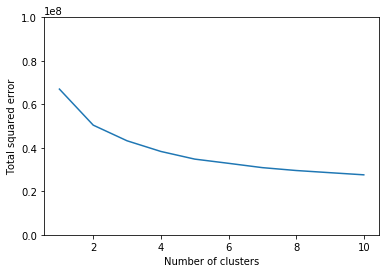

In [29]:
plt.plot(range(1, 11), SSE)
plt.ylim([0, 10e7])
plt.xlabel('Number of clusters')
plt.ylabel('Total squared error')

In [22]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(out_encodings)
classes = kmeans.predict(out_encodings)

Let's plot out what the clusters mean! One thing you want to ensure while doing this is that the clusters are physically meaningful in some way. Otherwise, it's neat to do machine learning, but machine learning without physical interpretability is useless.

(0, 8000)

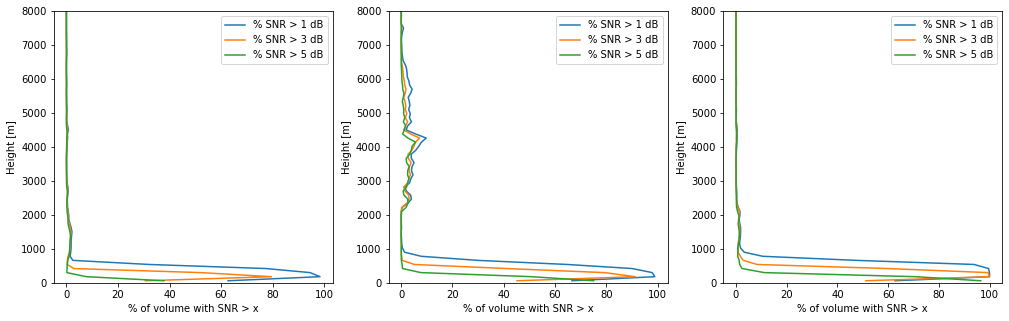

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
ax[0].plot(np.nanmean(snr_scp[classes == 0, 0:99], axis=0), my_ds.range_bins, label='% SNR > 1 dB')
ax[0].plot(np.nanmean(snr_scp[classes == 0, 99:198], axis=0), my_ds.range_bins, label='% SNR > 3 dB')
ax[0].plot(np.nanmean(snr_scp[classes == 0, 199:298], axis=0), my_ds.range_bins, label='% SNR > 5 dB')
ax[0].legend()
ax[0].set_xlabel('% of volume with SNR > x')
ax[0].set_ylabel('Height [m]')
ax[0].set_ylim([0, 8000])

ax[1].plot(np.nanmean(snr_scp[classes == 1, 0:99], axis=0), my_ds.range_bins, label='% SNR > 1 dB')
ax[1].plot(np.nanmean(snr_scp[classes == 1, 99:198], axis=0), my_ds.range_bins, label='% SNR > 3 dB')
ax[1].plot(np.nanmean(snr_scp[classes == 1, 199:298], axis=0), my_ds.range_bins, label='% SNR > 5 dB')
ax[1].legend()
ax[1].set_xlabel('% of volume with SNR > x')
ax[1].set_ylabel('Height [m]')
ax[1].set_ylim([0, 8000])

ax[2].plot(np.nanmean(snr_scp[classes == 2, 0:99], axis=0), my_ds.range_bins, label='% SNR > 1 dB')
ax[2].plot(np.nanmean(snr_scp[classes == 2, 99:198], axis=0), my_ds.range_bins, label='% SNR > 3 dB')
ax[2].plot(np.nanmean(snr_scp[classes == 2, 199:298], axis=0), my_ds.range_bins, label='% SNR > 5 dB')
ax[2].legend()
ax[2].set_xlabel('% of volume with SNR > x')
ax[2].set_ylabel('Height [m]')
ax[2].set_ylim([0, 8000])

In the left panel, we have a regime showing reduced echo coverage below 1 km compared to the right two panels. In addition, there are some times with mid level cloud. In the second panel, we see more high clouds, and some stronger echoes near the ground. I would call this regime "high cloud." The third panel has strong echoes near the ground, implying that this is probably a rainy regime.